In [2]:
# Install required packages if not available
%pip install lightgbm catboost optuna --quiet

Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Configuration

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Optuna for hyperparameter tuning
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
    print("✅ Optuna available for hyperparameter tuning")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️ Optuna not installed. Run: pip install optuna")

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Libraries loaded!")

✅ Optuna available for hyperparameter tuning
✅ Libraries loaded!


In [4]:
# Paths
BASE_DIR = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_DIR = BASE_DIR / "data"
EXPORTED_DIR = DATA_DIR / "exported_data" / "per_asset"

OUTPUT_DIR = BASE_DIR / "models" / "xgboost_ensemble"
RESULTS_DIR = BASE_DIR / "results" / "xgboost_ensemble"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"📂 Data: {EXPORTED_DIR}")
print(f"📂 Output: {OUTPUT_DIR}")
print(f"📂 Results: {RESULTS_DIR}")

📂 Data: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\data\exported_data\per_asset
📂 Output: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost_ensemble
📂 Results: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\xgboost_ensemble


In [5]:
# Configuration - use correct assets from pipeline
ASSETS = ["INTC", "AAPL", "NVDA", "IEF", "HYG", "BIL"]

# Optuna tuning config
TUNING_CONFIG = {
    'n_trials': 50,                    # Number of hyperparameter combinations to try
    'timeout': 600,                     # Max time per asset (seconds)
    'n_jobs': -1,                       # Parallel trials (-1 = all cores)
    'enable_pruning': True              # Early stopping for bad trials
}

# Ensemble config
ENSEMBLE_CONFIG = {
    'models': ['xgboost', 'lightgbm', 'catboost'],
    'weighting': 'performance',         # 'equal', 'performance', or 'inverse_error'
    'min_weight': 0.1,                  # Minimum weight per model
    'normalize_weights': True
}

# Trading config
TRADING_CONFIG = {
    'transaction_cost': 0.001,
    'slippage': 0.0005,
    'min_position_change': 0.10
}

print("⚙️ Configuration loaded")

⚙️ Configuration loaded


## 2. Hyperparameter Search Spaces

In [6]:
def get_xgboost_search_space(trial):
    """
    Define XGBoost hyperparameter search space for Optuna.
    """
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'objective': 'reg:squarederror',
        'random_state': 42
        # Note: early_stopping_rounds handled via callbacks in XGBoost 3.x
    }

def get_lightgbm_search_space(trial):
    """
    Define LightGBM hyperparameter search space.
    """
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'verbose': -1
    }

def get_catboost_search_space(trial):
    """
    Define CatBoost hyperparameter search space.
    """
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=50),
        'loss_function': 'RMSE',
        'random_state': 42,
        'verbose': False
    }

print("✅ Search spaces defined")

✅ Search spaces defined


## 3. Optuna Optimization Functions

In [13]:
def optimize_xgboost(X_train, y_train, X_val, y_val, config):
    """
    Optimize XGBoost hyperparameters using Optuna.
    Uses native XGBoost training for proper callback support.
    """
    def objective(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
            'objective': 'reg:squarederror',
            'seed': 42,
            'eval_metric': 'rmse'
        }
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        
        # Use native XGBoost training for proper early stopping
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        early_stop = xgb.callback.EarlyStopping(
            rounds=50,
            save_best=True,
            maximize=False,
            data_name='validation',
            metric_name='rmse'
        )
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=n_estimators,
            evals=[(dval, 'validation')],
            callbacks=[early_stop],
            verbose_eval=False
        )
        
        y_pred = model.predict(dval)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        return rmse
    
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner() if config['enable_pruning'] else None
    )
    
    study.optimize(
        objective,
        n_trials=config['n_trials'],
        timeout=config['timeout'],
        n_jobs=1,  # XGBoost already uses multiple cores
        show_progress_bar=False
    )
    
    return study.best_params, study.best_value

def optimize_lightgbm(X_train, y_train, X_val, y_val, config):
    """
    Optimize LightGBM hyperparameters.
    """
    def objective(trial):
        params = get_lightgbm_search_space(trial)
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        return rmse
    
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner() if config['enable_pruning'] else None
    )
    
    study.optimize(
        objective,
        n_trials=config['n_trials'],
        timeout=config['timeout'],
        n_jobs=1,
        show_progress_bar=False
    )
    
    return study.best_params, study.best_value

def optimize_catboost(X_train, y_train, X_val, y_val, config):
    """
    Optimize CatBoost hyperparameters.
    """
    def objective(trial):
        params = get_catboost_search_space(trial)
        
        model = cb.CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=False
        )
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        return rmse
    
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner() if config['enable_pruning'] else None
    )
    
    study.optimize(
        objective,
        n_trials=config['n_trials'],
        timeout=config['timeout'],
        n_jobs=1,
        show_progress_bar=False
    )
    
    return study.best_params, study.best_value

print("✅ Optimization functions defined")

✅ Optimization functions defined


## 4. Ensemble Functions

In [14]:
def calculate_ensemble_weights(predictions_dict, y_true, config):
    """
    Calculate weights for ensemble based on validation performance.
    
    Args:
        predictions_dict: {'xgboost': y_pred, 'lightgbm': y_pred, ...}
        y_true: True values
        config: Ensemble configuration
    
    Returns:
        Dictionary of weights
    """
    if config['weighting'] == 'equal':
        n_models = len(predictions_dict)
        return {model: 1.0 / n_models for model in predictions_dict.keys()}
    
    elif config['weighting'] == 'performance':
        # Weight by R² score (higher is better)
        scores = {}
        for model, y_pred in predictions_dict.items():
            r2 = r2_score(y_true, y_pred)
            scores[model] = max(0, r2)  # Clip negative R² to 0
        
        # Normalize
        total = sum(scores.values())
        if total > 0:
            weights = {model: score / total for model, score in scores.items()}
        else:
            # Fallback to equal weights
            n_models = len(predictions_dict)
            weights = {model: 1.0 / n_models for model in predictions_dict.keys()}
    
    elif config['weighting'] == 'inverse_error':
        # Weight by inverse RMSE (lower error = higher weight)
        errors = {}
        for model, y_pred in predictions_dict.items():
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            errors[model] = 1.0 / (rmse + 1e-8)
        
        total = sum(errors.values())
        weights = {model: err / total for model, err in errors.items()}
    
    else:
        raise ValueError(f"Unknown weighting method: {config['weighting']}")
    
    # Enforce minimum weight
    if config.get('min_weight'):
        for model in weights:
            weights[model] = max(weights[model], config['min_weight'])
    
    # Re-normalize if needed
    if config.get('normalize_weights', True):
        total = sum(weights.values())
        weights = {model: w / total for model, w in weights.items()}
    
    return weights

def make_ensemble_prediction(models_dict, X, weights):
    """
    Make weighted ensemble prediction.
    Handles both native XGBoost Booster and sklearn-style models.
    """
    predictions = np.zeros(len(X))
    
    for model_name, model in models_dict.items():
        if model is not None:
            # Handle native XGBoost Booster
            if model_name == 'xgboost' and isinstance(model, xgb.Booster):
                dmatrix = xgb.DMatrix(X)
                pred = model.predict(dmatrix)
            else:
                pred = model.predict(X)
            predictions += weights[model_name] * pred
    
    return predictions

print("✅ Ensemble functions defined")

✅ Ensemble functions defined


## 5. Trading Simulation

In [9]:
def simulate_trading(y_true, y_pred, config, initial_capital=100000):
    """
    Simulate trading with transaction costs.
    """
    n_samples = len(y_true)
    positions = np.zeros(n_samples)
    portfolio_values = np.zeros(n_samples)
    trades = np.zeros(n_samples)
    costs = np.zeros(n_samples)
    
    current_position = 0.0
    cash = initial_capital
    
    for i in range(n_samples):
        # Target position based on prediction sign
        target_position = 1.0 if y_pred[i] > 0 else -1.0
        
        # Check threshold
        if abs(target_position - current_position) >= config['min_position_change']:
            trade_size = target_position - current_position
            cost = abs(trade_size) * (config['transaction_cost'] + config['slippage']) * initial_capital
            costs[i] = cost
            current_position = target_position
            trades[i] = 1
        
        positions[i] = current_position
        
        # P&L
        period_return = y_true.iloc[i] if hasattr(y_true, 'iloc') else y_true[i]
        pnl = current_position * period_return * initial_capital
        cash = cash + pnl - costs[i]
        portfolio_values[i] = cash
    
    # Metrics
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    returns = returns[~np.isnan(returns)]
    
    return {
        'total_return': (portfolio_values[-1] - initial_capital) / initial_capital,
        'sharpe_ratio': returns.mean() / (returns.std() + 1e-8) * np.sqrt(252),
        'total_trades': trades.sum(),
        'total_costs': costs.sum(),
        'portfolio_values': portfolio_values
    }

print("✅ Trading simulation defined")

✅ Trading simulation defined


## 6. Load Data

In [10]:
def load_asset_data(asset):
    """
    Load train/val/test data.
    """
    asset_dir = EXPORTED_DIR / asset
    
    X_train = pd.read_csv(asset_dir / "X_train.csv", index_col=0, parse_dates=True)
    X_val = pd.read_csv(asset_dir / "X_val.csv", index_col=0, parse_dates=True)
    X_test = pd.read_csv(asset_dir / "X_test.csv", index_col=0, parse_dates=True)
    
    y_train = pd.read_csv(asset_dir / "y_train.csv", index_col=0, parse_dates=True).squeeze()
    y_val = pd.read_csv(asset_dir / "y_val.csv", index_col=0, parse_dates=True).squeeze()
    y_test = pd.read_csv(asset_dir / "y_test.csv", index_col=0, parse_dates=True).squeeze()
    
    return X_train, X_val, X_test, y_train, y_val, y_test

print("✅ Data loading defined")

✅ Data loading defined


## 7. Main Training Pipeline

In [15]:
def train_ensemble_for_asset(asset):
    """
    Complete ensemble training pipeline for one asset.
    """
    print(f"\n{'='*80}")
    print(f"Training Ensemble for {asset}")
    print(f"{'='*80}")
    
    # Load data
    X_train, X_val, X_test, y_train, y_val, y_test = load_asset_data(asset)
    print(f"\n📊 Data shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
    
    models = {}
    best_params = {}
    val_predictions = {}
    test_predictions = {}
    
    # Train XGBoost
    if 'xgboost' in ENSEMBLE_CONFIG['models']:
        print(f"\n🔍 Optimizing XGBoost...")
        if OPTUNA_AVAILABLE:
            params, best_score = optimize_xgboost(X_train, y_train, X_val, y_val, TUNING_CONFIG)
            print(f"  Best validation RMSE: {best_score:.6f}")
            best_params['xgboost'] = params
        else:
            # Default params
            params = {
                'learning_rate': 0.01, 'max_depth': 5,
                'objective': 'reg:squarederror', 'seed': 42, 'eval_metric': 'rmse'
            }
        
        # Use native XGBoost training for proper callback support
        n_estimators = params.pop('n_estimators', 500)
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test)
        
        early_stop = xgb.callback.EarlyStopping(
            rounds=50,
            save_best=True,
            maximize=False,
            data_name='validation',
            metric_name='rmse'
        )
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=n_estimators,
            evals=[(dval, 'validation')],
            callbacks=[early_stop],
            verbose_eval=False
        )
        models['xgboost'] = model
        val_predictions['xgboost'] = model.predict(dval)
        test_predictions['xgboost'] = model.predict(dtest)
        print(f"  ✅ XGBoost trained")
    
    # Train LightGBM
    if 'lightgbm' in ENSEMBLE_CONFIG['models']:
        print(f"\n🔍 Optimizing LightGBM...")
        if OPTUNA_AVAILABLE:
            params, best_score = optimize_lightgbm(X_train, y_train, X_val, y_val, TUNING_CONFIG)
            print(f"  Best validation RMSE: {best_score:.6f}")
            best_params['lightgbm'] = params
        else:
            params = {
                'learning_rate': 0.01, 'num_leaves': 31, 'n_estimators': 500,
                'objective': 'regression', 'random_state': 42, 'verbose': -1
            }
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        models['lightgbm'] = model
        val_predictions['lightgbm'] = model.predict(X_val)
        test_predictions['lightgbm'] = model.predict(X_test)
        print(f"  ✅ LightGBM trained")
    
    # Train CatBoost
    if 'catboost' in ENSEMBLE_CONFIG['models']:
        print(f"\n🔍 Optimizing CatBoost...")
        if OPTUNA_AVAILABLE:
            params, best_score = optimize_catboost(X_train, y_train, X_val, y_val, TUNING_CONFIG)
            print(f"  Best validation RMSE: {best_score:.6f}")
            best_params['catboost'] = params
        else:
            params = {
                'learning_rate': 0.01, 'depth': 5, 'iterations': 500,
                'loss_function': 'RMSE', 'random_state': 42, 'verbose': False
            }
        
        model = cb.CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=False
        )
        models['catboost'] = model
        val_predictions['catboost'] = model.predict(X_val)
        test_predictions['catboost'] = model.predict(X_test)
        print(f"  ✅ CatBoost trained")
    
    # Calculate ensemble weights
    print(f"\n⚖️ Calculating ensemble weights...")
    weights = calculate_ensemble_weights(val_predictions, y_val, ENSEMBLE_CONFIG)
    print(f"  Weights: {weights}")
    
    # Ensemble predictions
    ensemble_val_pred = make_ensemble_prediction(models, X_val, weights)
    ensemble_test_pred = make_ensemble_prediction(models, X_test, weights)
    
    # Evaluate
    test_rmse = np.sqrt(mean_squared_error(y_test, ensemble_test_pred))
    test_r2 = r2_score(y_test, ensemble_test_pred)
    test_dir_acc = np.mean(np.sign(y_test) == np.sign(ensemble_test_pred))
    
    print(f"\n📈 Ensemble Test Metrics:")
    print(f"  RMSE: {test_rmse:.6f}")
    print(f"  R²: {test_r2:.4f}")
    print(f"  Directional Accuracy: {test_dir_acc:.2%}")
    
    # Compare individual models
    print(f"\n📊 Individual Model Performance (Test):")
    for model_name, pred in test_predictions.items():
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2 = r2_score(y_test, pred)
        print(f"  {model_name}: RMSE={rmse:.6f}, R²={r2:.4f}")
    
    # Trading simulation
    print(f"\n💰 Running trading simulation...")
    trading_results = simulate_trading(y_test, ensemble_test_pred, TRADING_CONFIG)
    print(f"  Total Return: {trading_results['total_return']:.2%}")
    print(f"  Sharpe Ratio: {trading_results['sharpe_ratio']:.4f}")
    print(f"  Total Trades: {int(trading_results['total_trades'])}")
    print(f"  Total Costs: ${trading_results['total_costs']:.2f}")
    
    return {
        'asset': asset,
        'models': models,
        'best_params': best_params,
        'weights': weights,
        'predictions': {
            'val': ensemble_val_pred,
            'test': ensemble_test_pred
        },
        'individual_predictions': test_predictions,
        'actuals': {'val': y_val, 'test': y_test},
        'metrics': {
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'test_dir_acc': test_dir_acc
        },
        'trading_results': trading_results
    }

print("✅ Training pipeline defined")

✅ Training pipeline defined


## 8. Train All Assets

In [16]:
all_results = {}

for asset in ASSETS:
    try:
        result = train_ensemble_for_asset(asset)
        all_results[asset] = result
        print(f"\n✅ {asset} ensemble complete!\n")
    except Exception as e:
        print(f"\n❌ Error processing {asset}: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print(f"✅ All Assets Trained!")
print(f"{'='*80}")


Training Ensemble for INTC

📊 Data shapes: Train=(1706, 76), Val=(756, 76), Test=(1004, 76)

🔍 Optimizing XGBoost...
  Best validation RMSE: 0.012358
  Best validation RMSE: 0.012358
  ✅ XGBoost trained

🔍 Optimizing LightGBM...
  ✅ XGBoost trained

🔍 Optimizing LightGBM...
  Best validation RMSE: 0.008581
  Best validation RMSE: 0.008581
  ✅ LightGBM trained

🔍 Optimizing CatBoost...
  ✅ LightGBM trained

🔍 Optimizing CatBoost...
  Best validation RMSE: 0.008640
  Best validation RMSE: 0.008640
  ✅ CatBoost trained

⚖️ Calculating ensemble weights...
  Weights: {'xgboost': 0.25682964816282605, 'lightgbm': 0.3729062866240061, 'catboost': 0.3702640652131678}

📈 Ensemble Test Metrics:
  RMSE: 0.011044
  R²: 0.7000
  Directional Accuracy: 84.36%

📊 Individual Model Performance (Test):
  xgboost: RMSE=0.014651, R²=0.4722
  lightgbm: RMSE=0.010552, R²=0.7262
  catboost: RMSE=0.010573, R²=0.7251

💰 Running trading simulation...
  Total Return: 1251.42%
  Sharpe Ratio: 8.7364
  Total Trades:

## 9. Results Analysis

In [17]:
# Summary table
summary_df = pd.DataFrame([
    {
        'Asset': asset,
        'Test_RMSE': result['metrics']['test_rmse'],
        'Test_R2': result['metrics']['test_r2'],
        'Dir_Acc': result['metrics']['test_dir_acc'],
        'Total_Return': result['trading_results']['total_return'],
        'Sharpe': result['trading_results']['sharpe_ratio'],
        'N_Trades': result['trading_results']['total_trades'],
        'XGB_Weight': result['weights'].get('xgboost', 0),
        'LGB_Weight': result['weights'].get('lightgbm', 0),
        'CB_Weight': result['weights'].get('catboost', 0)
    }
    for asset, result in all_results.items()
])

print("\n📊 Ensemble Performance Summary:")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)


📊 Ensemble Performance Summary:
Asset  Test_RMSE  Test_R2  Dir_Acc  Total_Return    Sharpe  N_Trades  XGB_Weight  LGB_Weight  CB_Weight
 INTC   0.011044 0.700048 0.843625     12.514211  8.736412     432.0    0.256830    0.372906   0.370264
 AAPL   0.007461 0.776710 0.870518      9.933190  9.604351     409.0    0.219001    0.399461   0.381538
 NVDA   0.011738 0.777879 0.893426     18.283643 10.330936     408.0    0.233223    0.387043   0.379734
  IEF   0.002562 0.750581 0.892430      2.382909  9.666807     447.0    0.090909    0.442306   0.466785
  HYG   0.002434 0.763827 0.875498      1.994389  7.595192     415.0    0.093253    0.461125   0.445623
  BIL   0.000132 0.420295 0.723108     -0.828123 -6.446330     325.0    0.090909    0.435793   0.473298


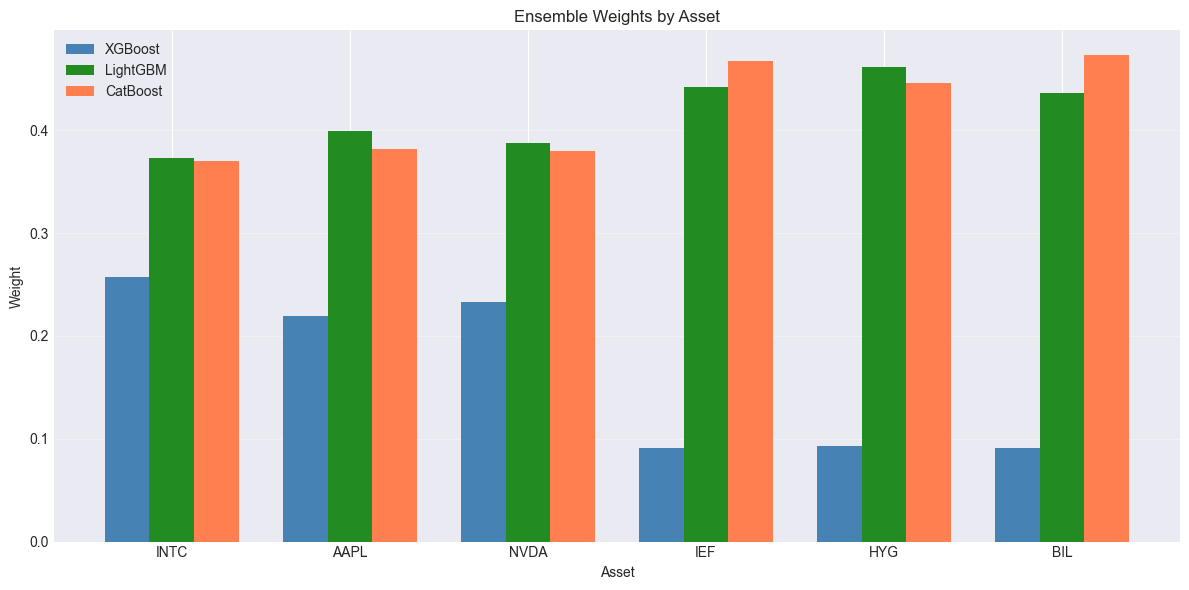

✅ Ensemble weights visualization saved


In [18]:
# Visualize ensemble weights
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(ASSETS))
width = 0.25

xgb_weights = [all_results[asset]['weights'].get('xgboost', 0) for asset in ASSETS]
lgb_weights = [all_results[asset]['weights'].get('lightgbm', 0) for asset in ASSETS]
cb_weights = [all_results[asset]['weights'].get('catboost', 0) for asset in ASSETS]

ax.bar(x - width, xgb_weights, width, label='XGBoost', color='steelblue')
ax.bar(x, lgb_weights, width, label='LightGBM', color='forestgreen')
ax.bar(x + width, cb_weights, width, label='CatBoost', color='coral')

ax.set_xlabel('Asset')
ax.set_ylabel('Weight')
ax.set_title('Ensemble Weights by Asset')
ax.set_xticks(x)
ax.set_xticklabels(ASSETS)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ensemble_weights.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Ensemble weights visualization saved")

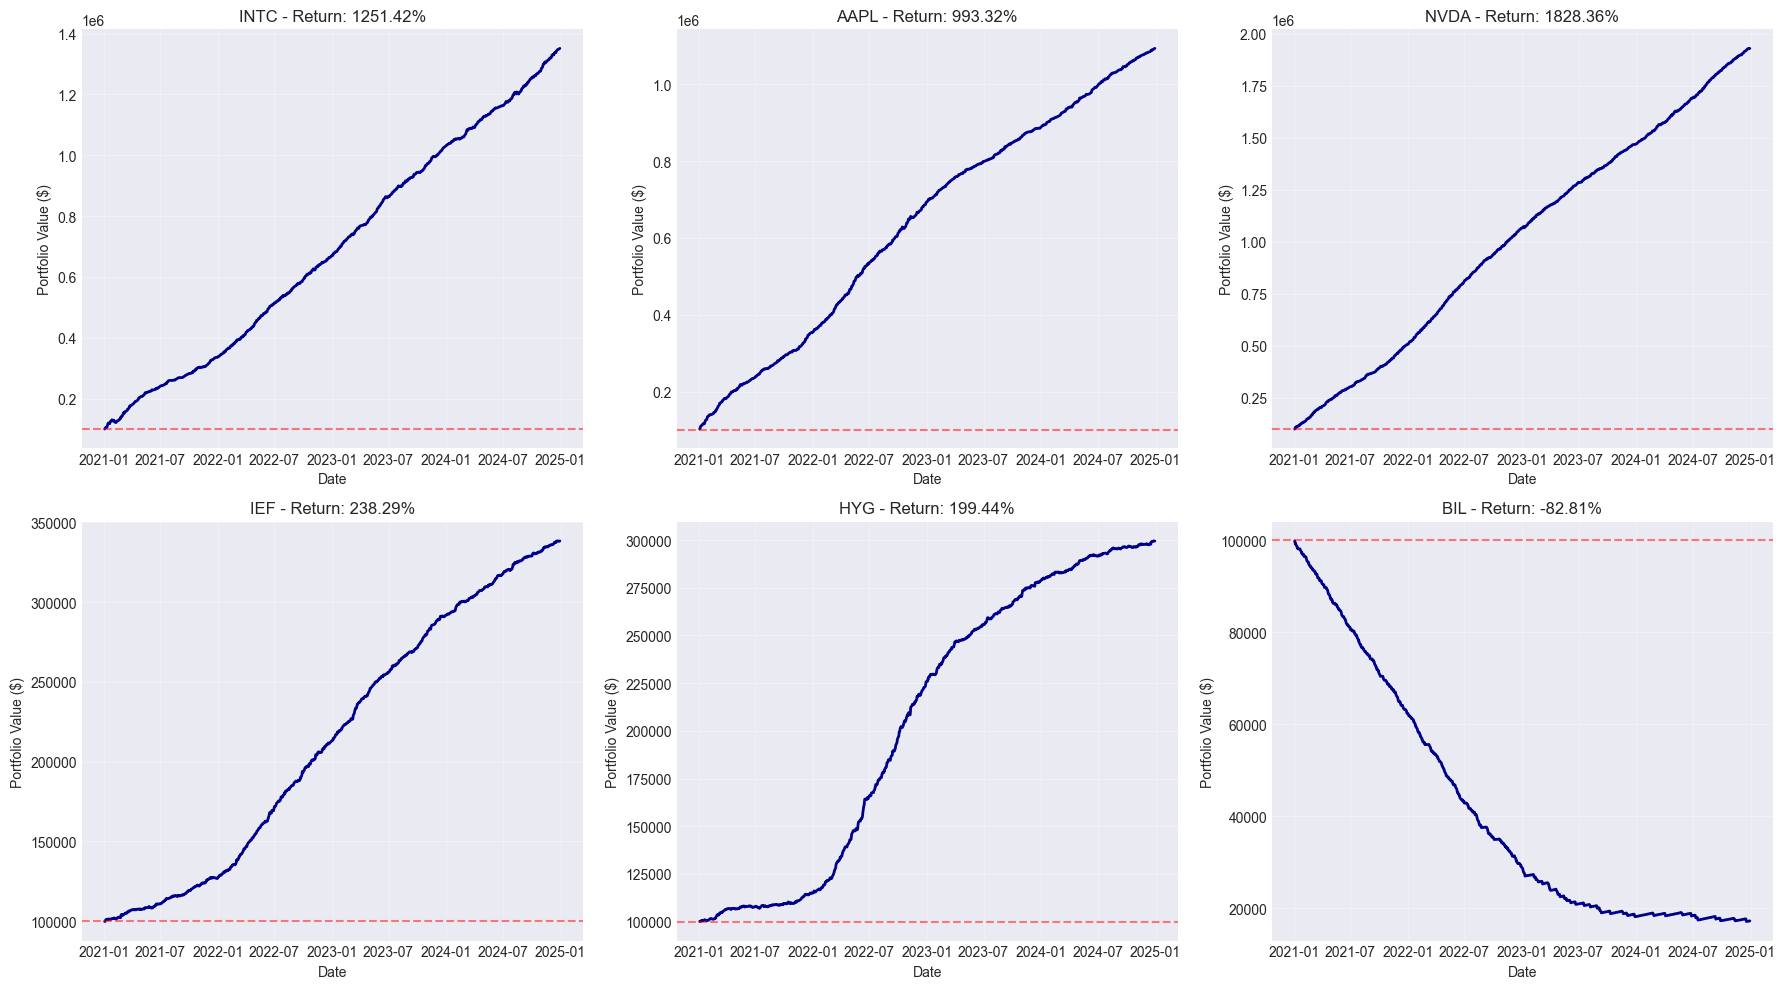

✅ Equity curves saved


In [19]:
# Plot equity curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (asset, result) in enumerate(all_results.items()):
    portfolio = result['trading_results']['portfolio_values']
    dates = result['actuals']['test'].index
    
    axes[idx].plot(dates, portfolio, linewidth=2, color='darkblue')
    axes[idx].axhline(y=100000, color='red', linestyle='--', alpha=0.5)
    axes[idx].set_title(f"{asset} - Return: {result['trading_results']['total_return']:.2%}")
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Portfolio Value ($)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ensemble_equity_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Equity curves saved")

## 10. Save Results

In [20]:
# Save models and results
for asset, result in all_results.items():
    # Save each model
    for model_name, model in result['models'].items():
        model_path = OUTPUT_DIR / f'{asset}_{model_name}_model.joblib'
        joblib.dump(model, model_path)
    
    # Save ensemble metadata
    metadata = {
        'asset': asset,
        'weights': result['weights'],
        'best_params': result['best_params'],
        'metrics': result['metrics'],
        'trading_results': {
            k: float(v) if isinstance(v, (np.floating, np.integer)) else v
            for k, v in result['trading_results'].items()
            if k != 'portfolio_values'
        }
    }
    
    with open(OUTPUT_DIR / f'{asset}_ensemble_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Save predictions
    pred_df = pd.DataFrame({
        'date': result['actuals']['test'].index,
        'true': result['actuals']['test'].values,
        'ensemble_pred': result['predictions']['test'],
        **{f'{m}_pred': result['individual_predictions'][m] for m in result['individual_predictions']}
    })
    pred_df.to_csv(OUTPUT_DIR / f'{asset}_ensemble_predictions.csv', index=False)
    
    print(f"✅ {asset} saved")

# Save summary
summary_df.to_csv(RESULTS_DIR / 'ensemble_summary.csv', index=False)

# Save config
config = {
    'training_date': datetime.now().isoformat(),
    'tuning_config': TUNING_CONFIG,
    'ensemble_config': ENSEMBLE_CONFIG,
    'trading_config': TRADING_CONFIG
}

with open(OUTPUT_DIR / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("\n✅ All results saved!")

✅ INTC saved
✅ AAPL saved
✅ NVDA saved
✅ IEF saved
✅ HYG saved
✅ BIL saved

✅ All results saved!
✅ HYG saved
✅ BIL saved

✅ All results saved!


## 11. Final Report

In [21]:
print("\n" + "="*80)
print("ENSEMBLE TRAINING COMPLETE!")
print("="*80)

print(f"\n✅ Features Implemented:")
print(f"  1. Hyperparameter Tuning:")
if OPTUNA_AVAILABLE:
    print(f"     - Optuna optimization: {TUNING_CONFIG['n_trials']} trials per asset")
    print(f"     - Asset-specific parameters: YES")
else:
    print(f"     - Using default parameters (install optuna for optimization)")

print(f"\n  2. Ensemble Models:")
print(f"     - Models: {', '.join(ENSEMBLE_CONFIG['models'])}")
print(f"     - Weighting: {ENSEMBLE_CONFIG['weighting']}")
print(f"     - Minimum weight: {ENSEMBLE_CONFIG['min_weight']}")

print(f"\n  3. Trading Simulation:")
print(f"     - Transaction cost: {TRADING_CONFIG['transaction_cost']*100}%")
print(f"     - Slippage: {TRADING_CONFIG['slippage']*100}%")

print(f"\n📊 Best Performers:")
best_sharpe = summary_df.loc[summary_df['Sharpe'].idxmax()]
best_return = summary_df.loc[summary_df['Total_Return'].idxmax()]
print(f"  Best Sharpe: {best_sharpe['Asset']} ({best_sharpe['Sharpe']:.4f})")
print(f"  Best Return: {best_return['Asset']} ({best_return['Total_Return']:.2%})")

print(f"\n📁 Outputs:")
print(f"  Models: {OUTPUT_DIR}")
print(f"  Results: {RESULTS_DIR}")

print(f"\n✅ Production-ready ensemble with optimized hyperparameters!")
print("="*80)


ENSEMBLE TRAINING COMPLETE!

✅ Features Implemented:
  1. Hyperparameter Tuning:
     - Optuna optimization: 50 trials per asset
     - Asset-specific parameters: YES

  2. Ensemble Models:
     - Models: xgboost, lightgbm, catboost
     - Weighting: performance
     - Minimum weight: 0.1

  3. Trading Simulation:
     - Transaction cost: 0.1%
     - Slippage: 0.05%

📊 Best Performers:
  Best Sharpe: NVDA (10.3309)
  Best Return: NVDA (1828.36%)

📁 Outputs:
  Models: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost_ensemble
  Results: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\xgboost_ensemble

✅ Production-ready ensemble with optimized hyperparameters!
